In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
#import h5py
import math
import time
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import innvestigate
import innvestigate.utils as iutils

import os

1.13.1


In [3]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'}
# plt.rc('font', family='default')
# plt.rcParams['figure.dpi'] = 115
plt.rcParams.update(params)
plt.style.context('default')

In [4]:
test_data = np.load("./ShowJet_full_test.npz")
test_images = test_data['jetImages']
test_labels = test_data['labels']
# test_labels_sig=test_data['labels_sig']

In [5]:
# def model_wo_sigmoid(model):
#     for i in range(len(model.layers)):
#         if (model.layers[i].get_config()['name'] == 'sigmoid'):
#             return models.Model(model.layers[0].input,model.layers[i-1].output)

In [6]:
'''lrp rule : 'lrp', 'lrp.z', 'lrp.z_IB', 'lrp.epsilon', 'lrp.epsilon_IB',
              'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1',
              'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB',
              'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a',
              'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat',
              'lrp.sequential_preset_b_flat' ''' 
# _IB -> Ignore Bias
def GetRelevance(model, lrp_rule, data):
    '''Inputs: model_name - keras.model,
               lrp_rule - str, data - array of shape (n, 1,16,16,1)'''
#     if (model.layers[-1].get_config()['name'] == 'softmax'):
    model_ws = iutils.keras.graph.model_wo_softmax(model)
#     elif (model.layers[-1].get_config()['name'] == 'sigmoid'):
#         model_ws = model_wo_sigmoid(model)
    lrp_analyzer = innvestigate.create_analyzer(lrp_rule, model_ws)
    data = data.reshape(len(data), 1, 16, 16, 1)
    start = time.time()
    rel_scores = [lrp_analyzer.analyze(data[i]) for i in range(len(data))]
    print('time = ', time.time()-start, ' sec')
    return np.array(rel_scores).reshape(len(rel_scores), 16, 16, 1)

In [7]:
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    image_model = load_model('model/CNN_imageonly_full_morefilters_2.h1')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 16, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
maxpool2x2_1 (MaxPooling2D)  (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
relu (Dense)                 (None, 256)               2097408   
__________

In [9]:
predict = image_model.predict(test_images)

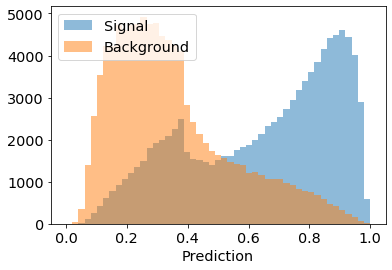

In [10]:
sig = predict[(test_data['labels'][:,1]==1)][:,1]
bkg = predict[(test_data['labels'][:,0]==1)][:,1]

bins = np.linspace(0, 1, 50)

plt.hist(sig, bins, alpha=0.5, label='Signal')
plt.hist(bkg, bins, alpha=0.5, label='Background')

plt.legend(loc='upper left')
plt.xlabel('Prediction')
plt.show()

In [11]:
cut = 0.6

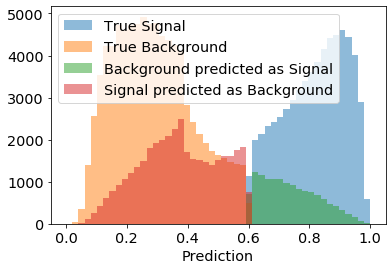

In [12]:
sig_tp = predict[(test_data['labels'][:,1]==1) & (predict[:,1]>=cut)][:,1]
bkg_tn = predict[(test_data['labels'][:,0]==1) & (predict[:,1]<cut)][:,1]
sig_fp = predict[(test_data['labels'][:,0]==1) & (predict[:,1]>=cut)][:,1]
bkg_fn = predict[(test_data['labels'][:,1]==1) & (predict[:,1]<cut)][:,1]

bins = np.linspace(0, 1, 50)

plt.hist(sig_tp, bins, alpha=0.5, label='True Signal')
plt.hist(bkg_tn, bins, alpha=0.5, label='True Background')
plt.hist(sig_fp, bins, alpha=0.5, label='Background predicted as Signal')
plt.hist(bkg_fn, bins, alpha=0.5, label='Signal predicted as Background')
plt.legend(loc='upper left')
plt.xlabel('Prediction')
plt.show()

In [71]:
index1 = np.argwhere((test_labels[:,1]==1)&(predict[:,1]>cut)) # True Positive - correctly precited as Signal

index2 = np.argwhere((test_labels[:,0]==1)&(predict[:,1]>cut)) # False Positive - precited as Signal but is a Background image

index3 = np.argwhere((test_labels[:,1]==1)&(predict[:,1]<=cut)) # False Negative - precited as Background but is a Signal image

index4 = np.argwhere((test_labels[:,0]==1)&(predict[:,1]<=cut)) # True Negative - correctly precited as Background

In [72]:
signal_eff = np.sum(index1)/(np.sum(index1)+np.sum(index2))
print(signal_eff)

0.8212953459198017


In [110]:
bkg_eff = np.sum(index4)/(np.sum(index3)+np.sum(index4))
print(bkg_eff)

0.6953532364738558


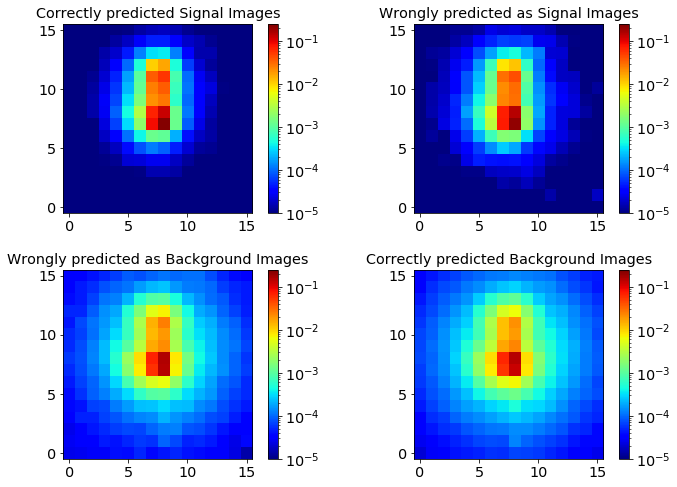

In [73]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3, wspace =0.1)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(test_images[index1], axis=0).squeeze(), cmap='jet',interpolation='nearest',
                norm=LogNorm(), vmin = 0.00001, vmax= 0.25, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0])

im =axs[1].imshow(np.mean(test_images[index2], axis=0).squeeze(), cmap='jet',interpolation='nearest',
                norm=LogNorm(), vmin = 0.00001, vmax= 0.25, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1])

im =axs[2].imshow(np.mean(test_images[index3], axis=0).squeeze(), cmap='jet',interpolation='nearest',
                norm=LogNorm(), vmin = 0.00001, vmax= 0.25, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2])

im =axs[3].imshow(np.mean(test_images[index4], axis=0).squeeze(), cmap='jet', interpolation='nearest',
                norm=LogNorm(), vmin = 0.00001, vmax= 0.25, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3])

plt.show()

# LRP-Zero (LRP-Z)

In [16]:
pixel_relevance = GetRelevance(image_model, "lrp.z", test_images)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
time =  690.6984362602234  sec


### Confusion Matrix

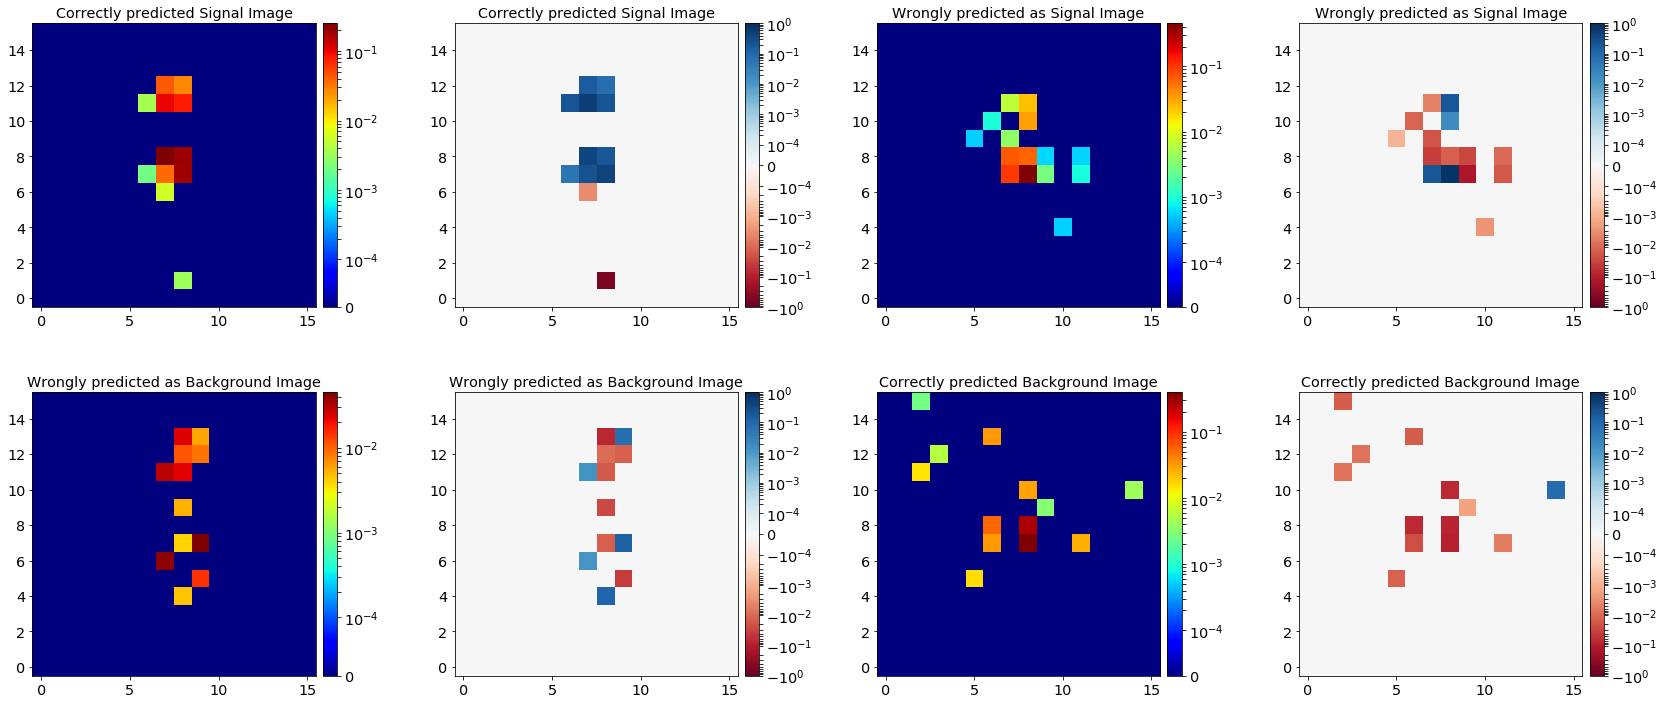

<Figure size 432x288 with 0 Axes>

In [107]:
i = 1
j = 7
k = 7
l = 8

fig, _axs = plt.subplots(nrows=2, ncols=4, figsize=(29, 12))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(test_images[index1][i].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[0].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(pixel_relevance[index1][i].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(test_images[index2][j].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[2].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(pixel_relevance[index2][j].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

im =axs[4].imshow(test_images[index3][k].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[4].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[4], fraction=0.0467, pad=0.02)

im =axs[5].imshow(pixel_relevance[index3][k].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[5].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[5], fraction=0.0467, pad=0.02)

im =axs[6].imshow(test_images[index4][l].squeeze(), cmap='jet', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[6].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[6], fraction=0.0467, pad=0.02)

im =axs[7].imshow(pixel_relevance[index4][l].squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[7].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[7], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_z_confMatrix_new.png')

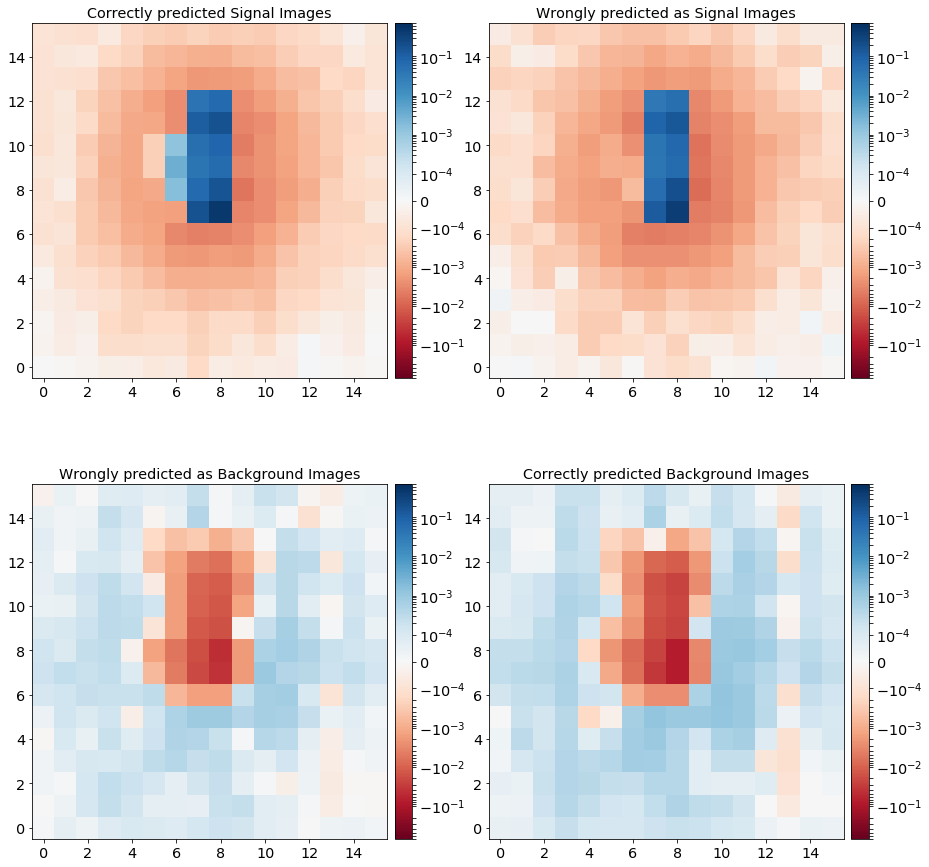

<Figure size 432x288 with 0 Axes>

In [82]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_z_mean_confMatrix_new.png')

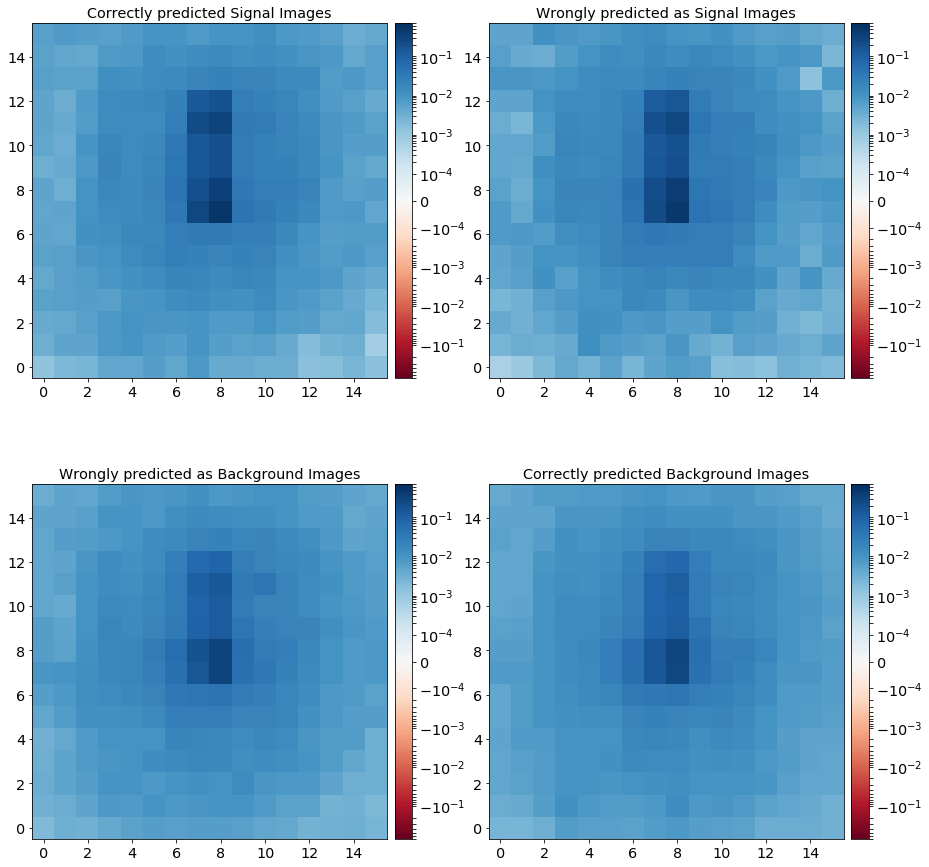

<Figure size 432x288 with 0 Axes>

In [83]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.std(pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.std(pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.std(pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.std(pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_z_std_confMatrix_new.png')

In [20]:
# pixel_relevance_IB = GetRelevance(image_model, "lrp.z_IB", test_images)

In [21]:
# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(221)
# im = plt.imshow(np.mean(pixel_relevance_IB[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Images')

# ax2 = fig.add_subplot(222)
# im = plt.imshow(np.mean(pixel_relevance_IB[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Images')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(np.mean(pixel_relevance_IB[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Images')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(np.mean(pixel_relevance_IB[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Images')

# plt.show()
# plt.savefig('plots/LRP_jetImages/lrp_zIB_mean_confMatrix.png')

In [22]:
# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(221)
# im = plt.imshow(np.std(pixel_relevance_IB[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Images')

# ax2 = fig.add_subplot(222)
# im = plt.imshow(np.std(pixel_relevance_IB[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Images')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(np.std(pixel_relevance_IB[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Images')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(np.std(pixel_relevance_IB[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Images')

# plt.show()
# plt.savefig('plots/LRP_jetImages/lrp_zIB_std_confMatrix.png')

# LRP-$\epsilon$

In [23]:
e_pixel_relevance = GetRelevance(image_model, "lrp.epsilon", test_images)

time =  695.2304828166962  sec


### Confusin Matrix

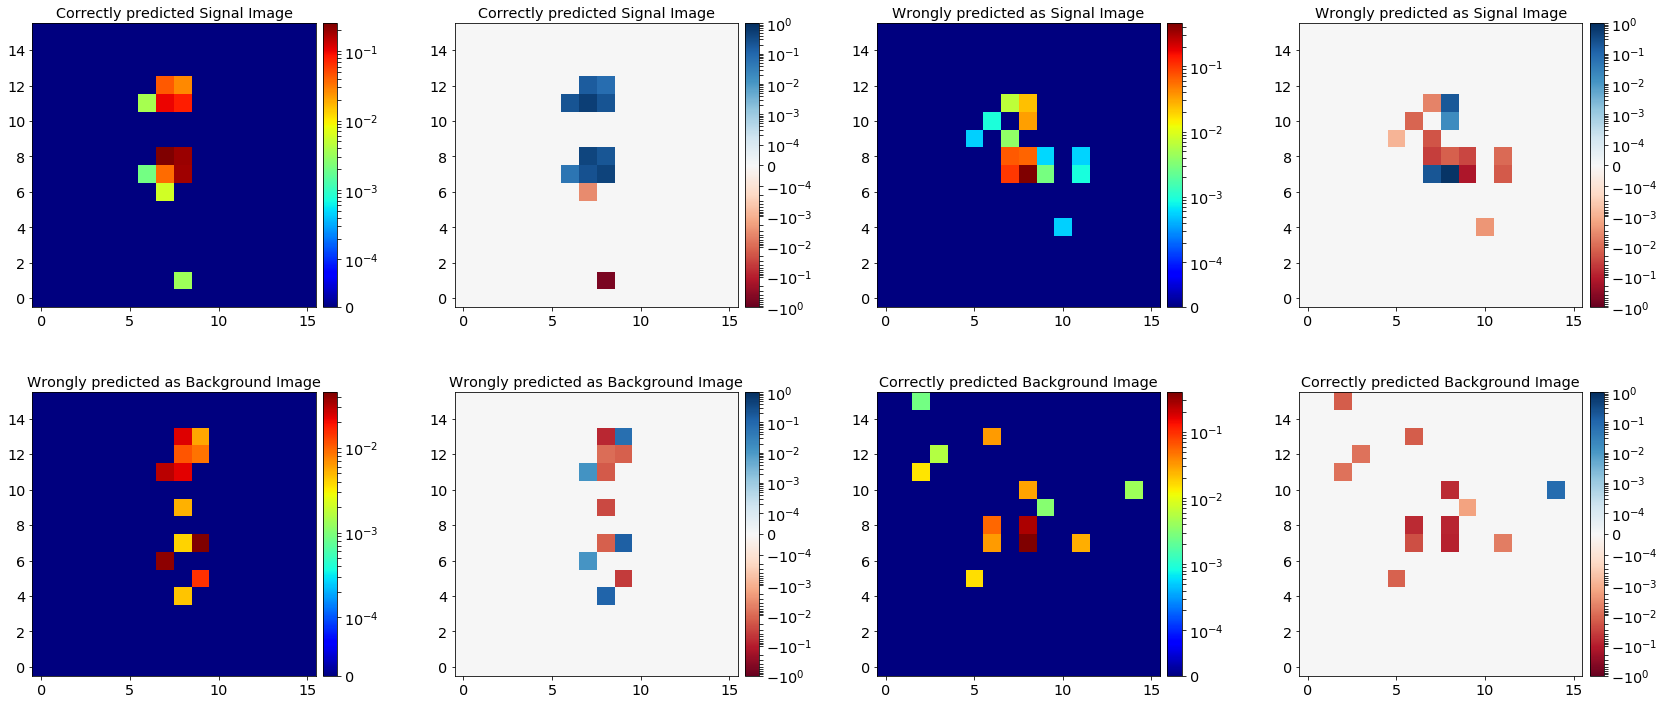

<Figure size 432x288 with 0 Axes>

In [106]:
i = 1
j = 7
k = 7
l = 8

fig, _axs = plt.subplots(nrows=2, ncols=4, figsize=(29, 12))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(test_images[index1][i].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[0].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(e_pixel_relevance[index1][i].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(test_images[index2][j].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[2].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(e_pixel_relevance[index2][j].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

im =axs[4].imshow(test_images[index3][k].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[4].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[4], fraction=0.0467, pad=0.02)

im =axs[5].imshow(e_pixel_relevance[index3][k].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[5].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[5], fraction=0.0467, pad=0.02)

im =axs[6].imshow(test_images[index4][l].squeeze(), cmap='jet', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[6].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[6], fraction=0.0467, pad=0.02)

im =axs[7].imshow(e_pixel_relevance[index4][l].squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[7].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[7], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_e_confMatrix_new.png')

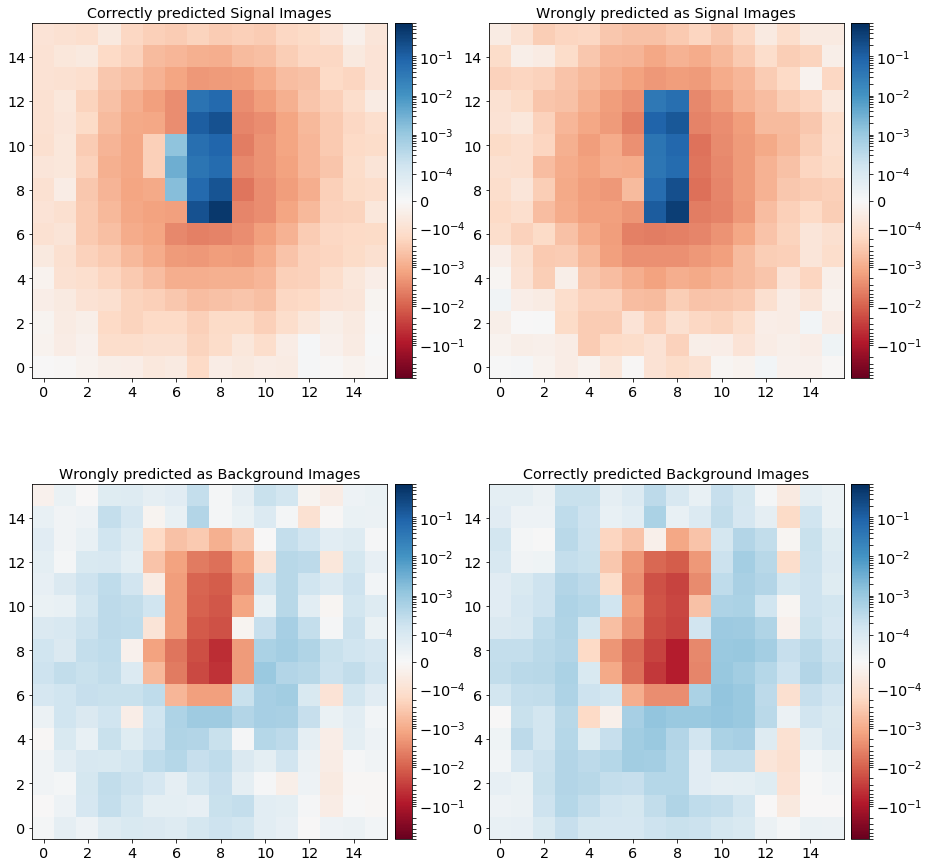

<Figure size 432x288 with 0 Axes>

In [85]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(e_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(e_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(e_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(e_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_e_mean_confMatrix_new.png')

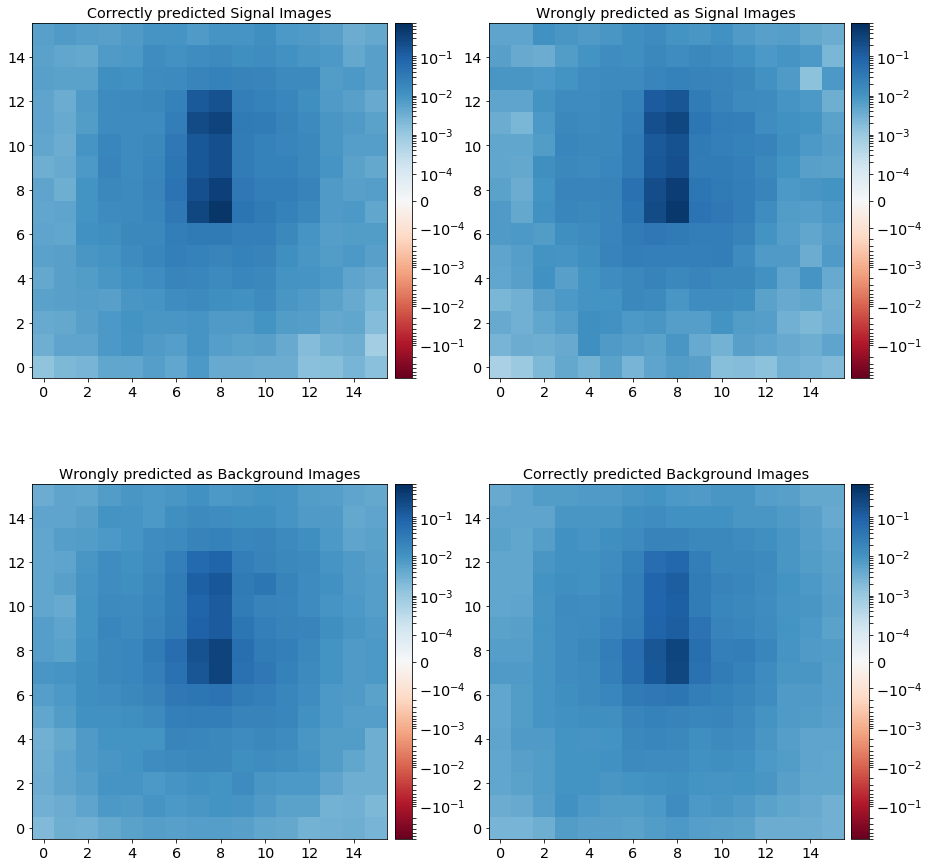

<Figure size 432x288 with 0 Axes>

In [86]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.std(e_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.std(e_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.std(e_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.std(e_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_e_std_confMatrix_new.png')

In [27]:
# e_pixel_relevance_IB = GetRelevance(image_model, "lrp.epsilon_IB", test_images)

In [28]:
# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(221)
# im = plt.imshow(np.mean(e_pixel_relevance_IB[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1,  origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Images')

# ax2 = fig.add_subplot(222)
# im = plt.imshow(np.mean(e_pixel_relevance_IB[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Images')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(np.mean(e_pixel_relevance_IB[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Images')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(np.mean(e_pixel_relevance_IB[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Images')

# plt.show()
# plt.savefig('plots/LRP_jetImages/lrp_eIB_mean_confMatrix.png')

# LRP-$\alpha$ $_1$ $\beta$ $_0$

In [29]:
g_pixel_relevance = GetRelevance(image_model, "lrp.alpha_1_beta_0", test_images)

time =  1344.5350589752197  sec


### Confusion Matrix

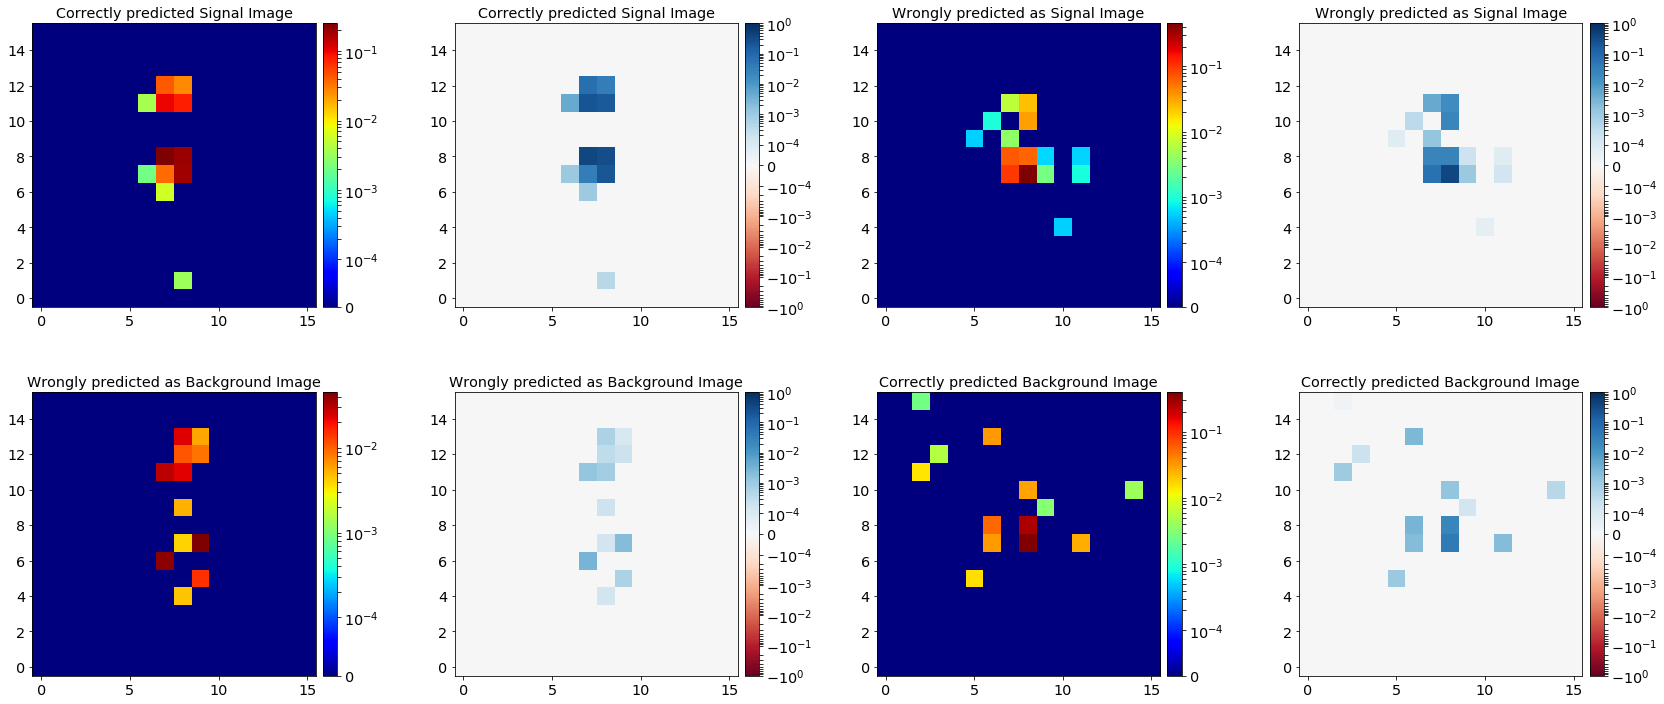

<Figure size 432x288 with 0 Axes>

In [105]:
i = 1
j = 7
k = 7
l = 8

fig, _axs = plt.subplots(nrows=2, ncols=4, figsize=(29, 12))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(test_images[index1][i].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[0].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(g_pixel_relevance[index1][i].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(test_images[index2][j].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[2].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(g_pixel_relevance[index2][j].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

im =axs[4].imshow(test_images[index3][k].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[4].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[4], fraction=0.0467, pad=0.02)

im =axs[5].imshow(g_pixel_relevance[index3][k].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[5].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[5], fraction=0.0467, pad=0.02)

im =axs[6].imshow(test_images[index4][l].squeeze(), cmap='jet', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[6].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[6], fraction=0.0467, pad=0.02)

im =axs[7].imshow(g_pixel_relevance[index4][l].squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[7].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[7], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_ab_confMatrix_new.png')

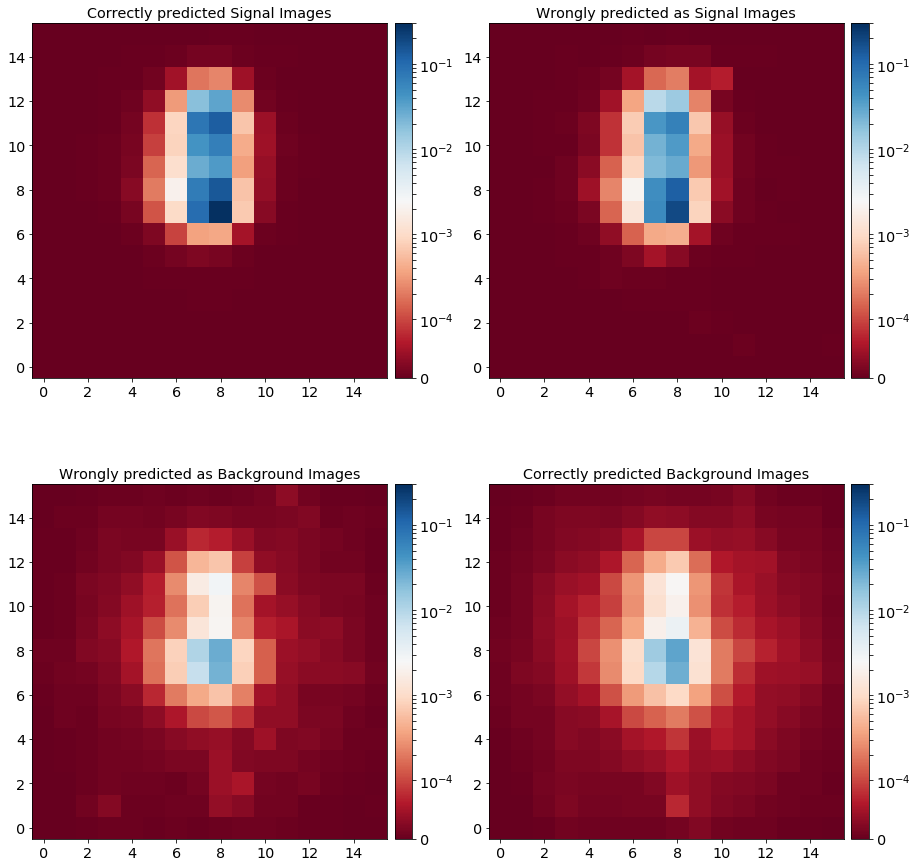

<Figure size 432x288 with 0 Axes>

In [88]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(g_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = 0, vmax= 0.3, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(g_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = 0, vmax= 0.3, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(g_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = 0, vmax= 0.3, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(g_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = 0, vmax= 0.3, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_ab_mean_confMatrix_new.png')

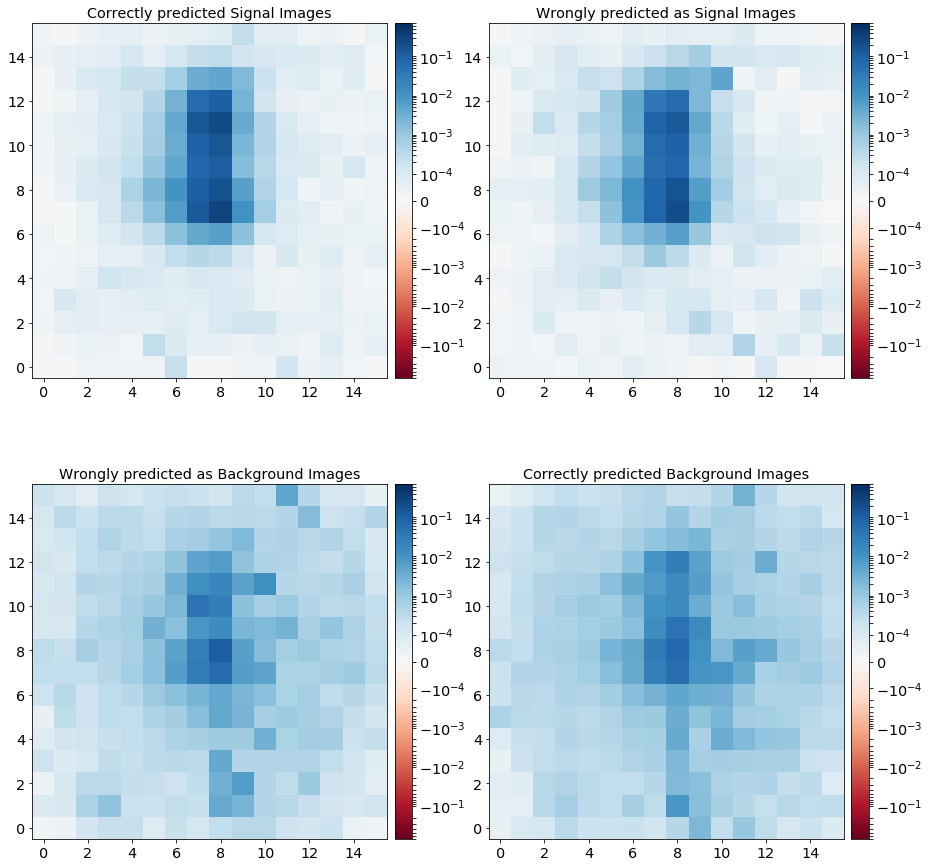

<Figure size 432x288 with 0 Axes>

In [89]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.std(g_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.std(g_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.std(g_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.std(g_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_ab_std_confMatrix_new.png')

In [33]:
# g_pixel_relevance_IB = GetRelevance(image_model, "lrp.alpha_1_beta_0_IB", test_images)

In [34]:
# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(221)
# im = plt.imshow(np.mean(g_pixel_relevance_IB[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001),  origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Images')

# ax2 = fig.add_subplot(222)
# im = plt.imshow(np.mean(g_pixel_relevance_IB[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001),  origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Images')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(np.mean(g_pixel_relevance_IB[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001),  origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Images')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(np.mean(g_pixel_relevance_IB[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001),  origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Images')

# plt.show()
# plt.savefig('plots/LRP_jetImages/lrp_abIB_mean_confMatrix.png')

# Sequential PresetA
### LRP-$\alpha$ $_1$ $\beta$ $_0$ for convolutional Layers and LRP-e for dense layers

In [35]:
p_pixel_relevance = GetRelevance(image_model, "lrp.sequential_preset_a", test_images)

time =  857.3197865486145  sec


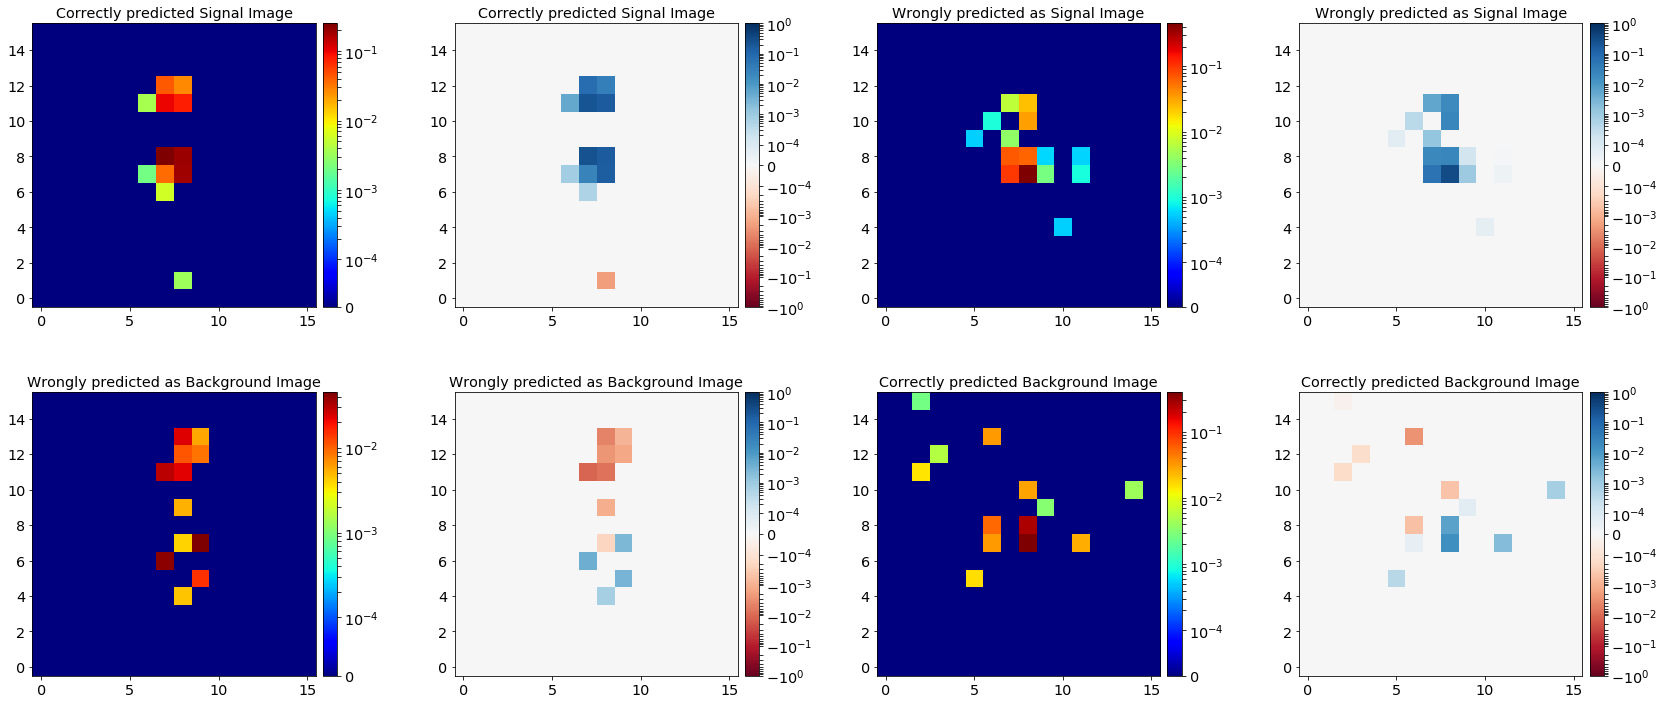

<Figure size 432x288 with 0 Axes>

In [104]:
i = 1
j = 7
k = 7
l = 8

fig, _axs = plt.subplots(nrows=2, ncols=4, figsize=(29, 12))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(test_images[index1][i].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[0].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(p_pixel_relevance[index1][i].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(test_images[index2][j].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[2].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(p_pixel_relevance[index2][j].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

im =axs[4].imshow(test_images[index3][k].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[4].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[4], fraction=0.0467, pad=0.02)

im =axs[5].imshow(p_pixel_relevance[index3][k].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[5].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[5], fraction=0.0467, pad=0.02)

im =axs[6].imshow(test_images[index4][l].squeeze(), cmap='jet', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[6].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[6], fraction=0.0467, pad=0.02)

im =axs[7].imshow(p_pixel_relevance[index4][l].squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[7].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[7], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_preA_confMatrix_new.png')

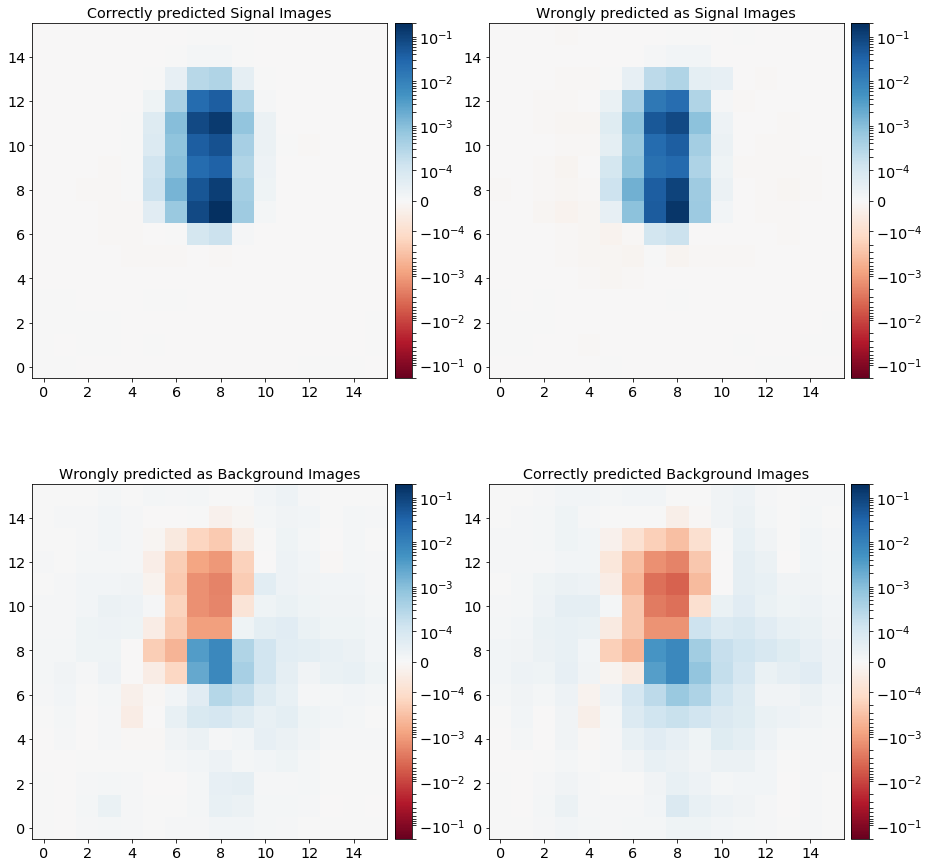

<Figure size 432x288 with 0 Axes>

In [91]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(p_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.2, vmax= 0.2, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(p_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.2, vmax= 0.2, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(p_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.2, vmax= 0.2, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(p_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.2, vmax= 0.2, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_preA_mean_confMatrix_new.png')

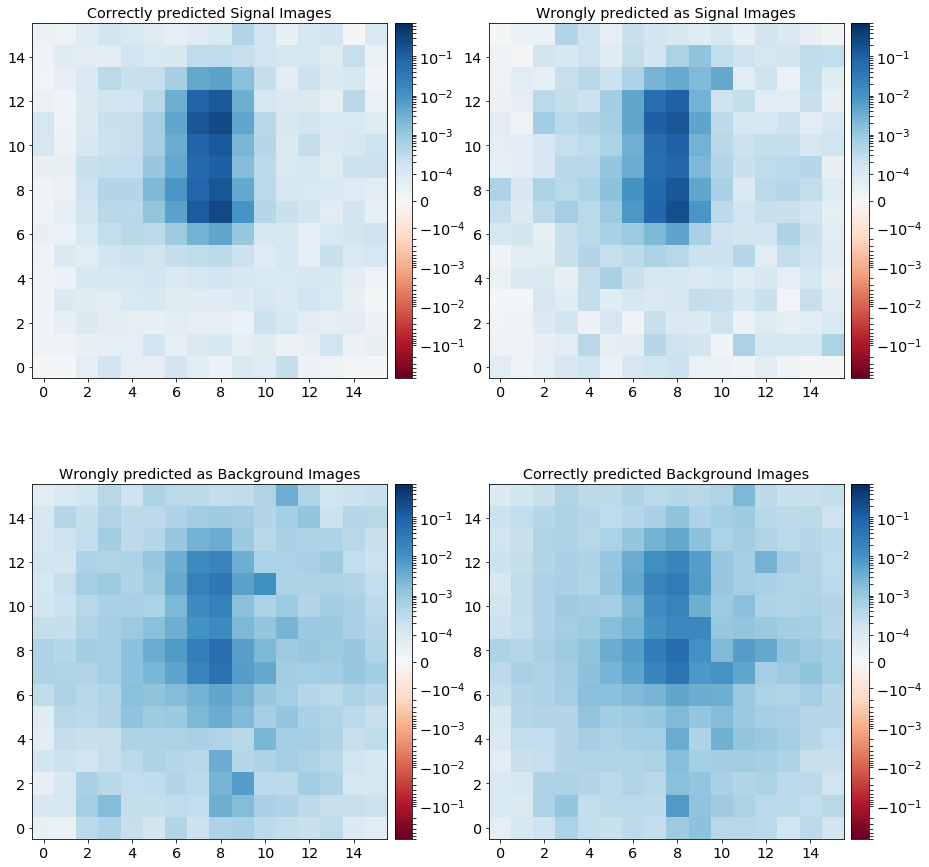

<Figure size 432x288 with 0 Axes>

In [92]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.std(p_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.std(p_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.std(p_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.std(p_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_preA_std_confMatrix_new.png')

In [39]:
# p_pixel_relevance_flat = GetRelevance(image_model, "lrp.sequential_preset_a_flat", test_images)

In [40]:
# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(221)
# im = plt.imshow(np.mean(p_pixel_relevance_flat[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Images')

# ax2 = fig.add_subplot(222)
# im = plt.imshow(np.mean(p_pixel_relevance_flat[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Images')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(np.mean(p_pixel_relevance_flat[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Images')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(np.mean(p_pixel_relevance_flat[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Images')

# plt.show()
# plt.savefig('plots/LRP_jetImages/lrp_preAflat_mean_confMatrix.png')

In [41]:
# Sequential PresetB
### LRP-$\alpha$ $_2$ $\beta$ $_1$ for convolutional Layers and LRP-e for dense layers

In [42]:
pB_pixel_relevance = GetRelevance(image_model, "lrp.sequential_preset_b", test_images)

time =  1120.2442588806152  sec


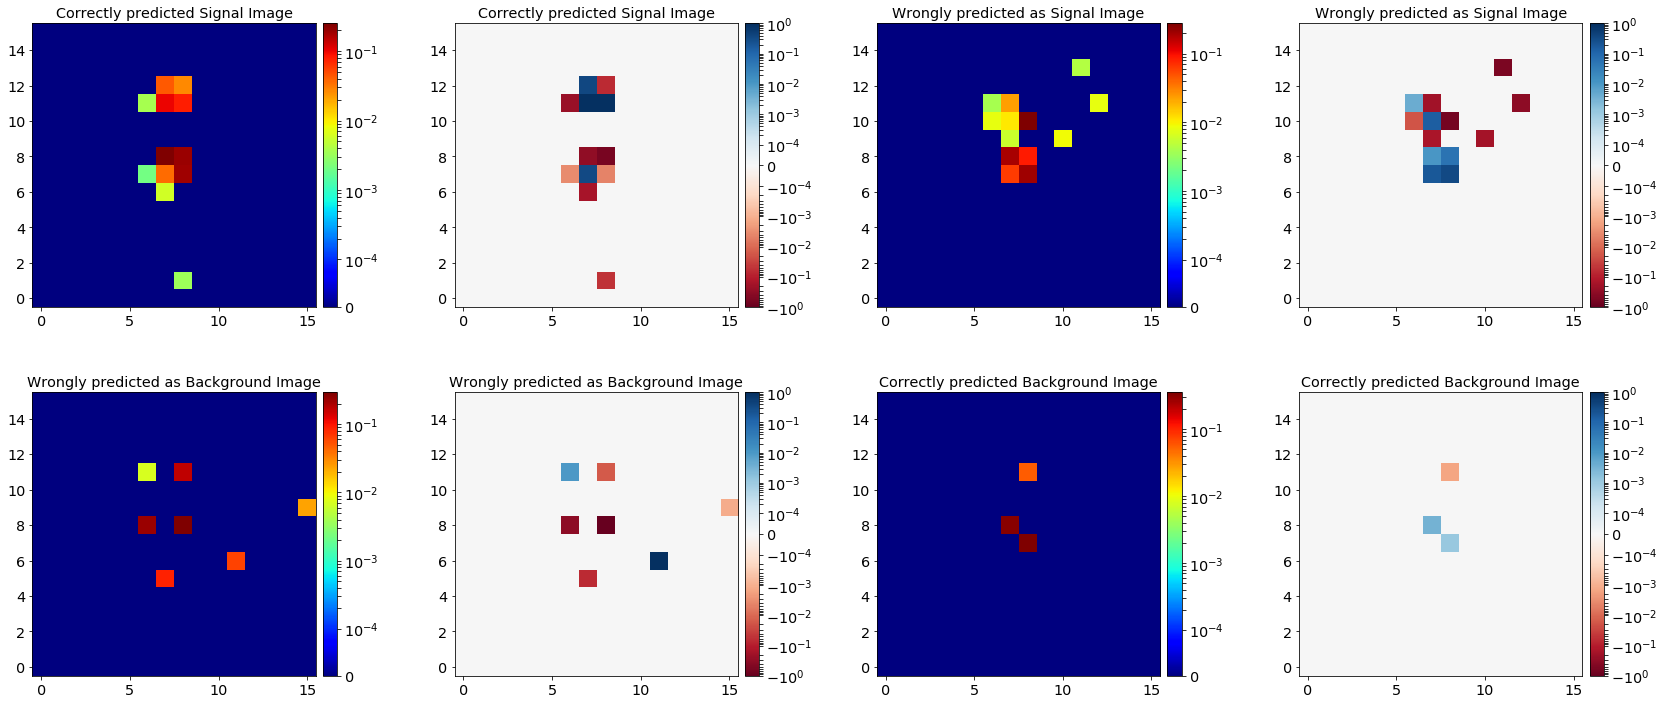

<Figure size 432x288 with 0 Axes>

In [43]:
i = 1
j = 7
k = 2
l = 3

fig, _axs = plt.subplots(nrows=2, ncols=4, figsize=(29, 12))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(test_images[index1][i].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[0].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(pB_pixel_relevance[index1][i].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Correctly predicted Signal Image")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(test_images[index2][j].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[2].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(pB_pixel_relevance[index2][j].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Wrongly predicted as Signal Image")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

im =axs[4].imshow(test_images[index3][k].squeeze(), cmap='jet',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[4].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[4], fraction=0.0467, pad=0.02)

im =axs[5].imshow(pB_pixel_relevance[index3][k].squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[5].set_title("Wrongly predicted as Background Image")
fig.colorbar(im, ax=axs[5], fraction=0.0467, pad=0.02)

im =axs[6].imshow(test_images[index4][l].squeeze(), cmap='jet', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), origin='low')
axs[6].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[6], fraction=0.0467, pad=0.02)

im =axs[7].imshow(pB_pixel_relevance[index4][l].squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[7].set_title("Correctly predicted Background Image")
fig.colorbar(im, ax=axs[7], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_preB_confMatrix_new.png')

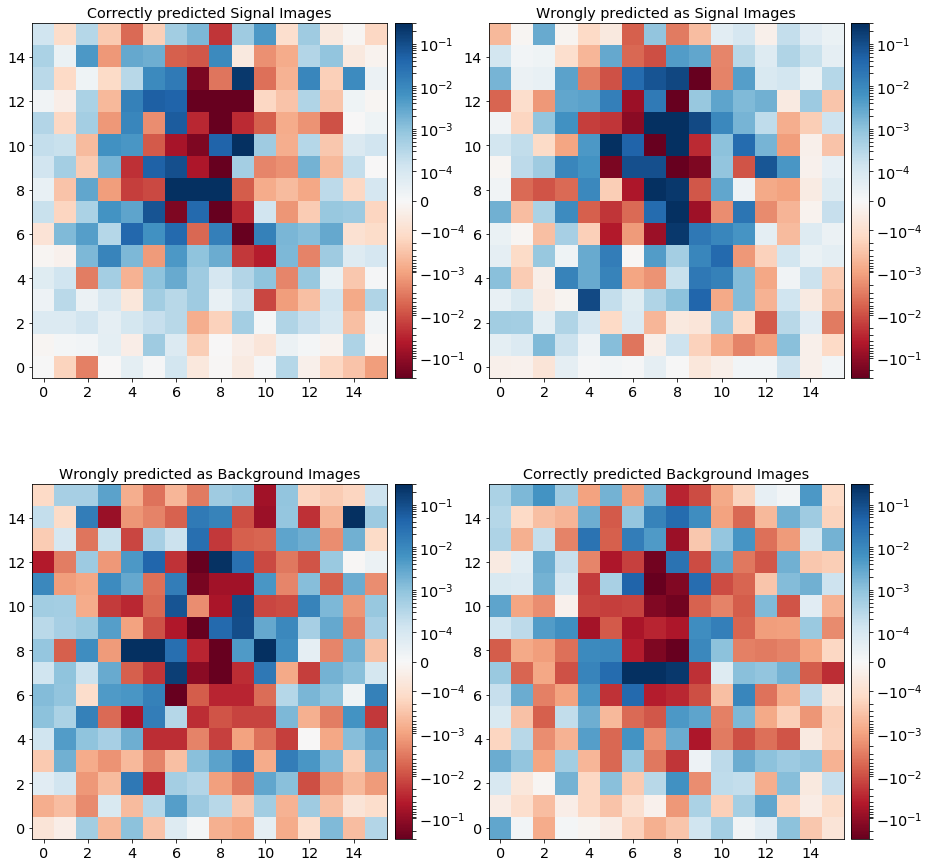

<Figure size 432x288 with 0 Axes>

In [44]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(pB_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.3, vmax= 0.3, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(pB_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.3, vmax= 0.3, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(pB_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.3, vmax= 0.3, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(pB_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.3, vmax= 0.3, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_preB_mean_confMatrix_new.png')

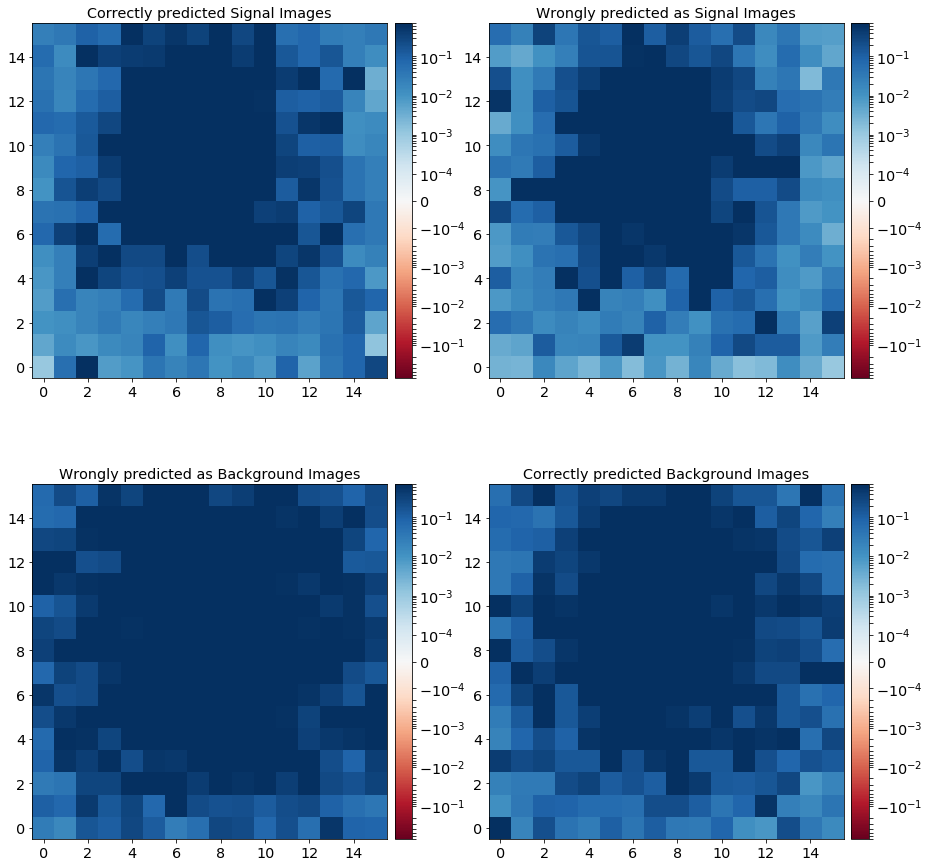

<Figure size 432x288 with 0 Axes>

In [45]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.std(pB_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.std(pB_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.std(pB_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.std(pB_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -0.7, vmax= 0.7, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()
plt.savefig('plots/LRP_jetImages/lrp_preB_std_confMatrix_new.png')

In [46]:
# Sigmoid Activation

In [47]:
# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
#     image_model_sigmoid = load_model('model/CNN_imageonly_full_morefilters_sigmoid.h1')

In [48]:
# predict_sigmoid =image_model_sigmoid.predict(test_images)

In [49]:
# index1_sig = np.argwhere((test_labels_sig==1)&((predict_sigmoid>0.7).flatten())) # True Positive - correctly precited as Signal

# index2_sig = np.argwhere((test_labels_sig==0)&((predict_sigmoid>0.7).flatten())) # False Positive - precited as Signal but is a Background image

# index3_sig = np.argwhere((test_labels_sig==0)&((predict_sigmoid<0.3).flatten())) # True Negative - correctly precited as Background

# index4_sig = np.argwhere((test_labels_sig==1)&((predict_sigmoid<0.3).flatten())) # False Negative - precited as Background but is a Signal image

In [50]:
# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(221)
# im = plt.imshow(np.mean(test_images[index1_sig], axis=0).squeeze(), cmap='jet',interpolation='nearest',
#                 norm=LogNorm(), vmin = 0.00001, vmax= 0.25, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Images')

# ax2 = fig.add_subplot(222)
# im = plt.imshow(np.mean(test_images[index2_sig], axis=0).squeeze(), cmap='jet',interpolation='nearest',
#                 norm=LogNorm(), vmin = 0.00001, vmax= 0.25, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Images')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(np.mean(test_images[index3_sig], axis=0).squeeze(), cmap='jet',interpolation='nearest',
#                 norm=LogNorm(), vmin = 0.00001, vmax= 0.25, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Images')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(np.mean(test_images[index4_sig], axis=0).squeeze(), cmap='jet', interpolation='nearest',
#                 norm=LogNorm(), vmin = 0.00001, vmax= 0.25, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Images')

# plt.show()
# plt.savefig('plots/LRP_jetImages/sigmoid_jetImages.png')

In [51]:
# Sequential PresetA
### LRP-$\alpha$ $_1$ $\beta$ $_0$ for convolutional Layers and LRP-e for dense layers

In [52]:
# relevance_sigmoid = GetRelevance(image_model_sigmoid, "lrp.sequential_preset_a", test_images)

In [53]:
# i = 0
# j = 8
# k = 7
# l = 1

# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(222)
# im = plt.imshow(relevance_sigmoid[index1_sig][i].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Image')

# ax1 = fig.add_subplot(221)
# im = plt.imshow(test_images[index1_sig][i].squeeze(), cmap='jet',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Image')

# ax3 = fig.add_subplot(224)
# im = plt.imshow(relevance_sigmoid[index3_sig][k].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Image')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(test_images[index3_sig][k].squeeze(), cmap='jet',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Image')

# plt.show()
# plt.savefig('plots/LRP_jetImages/sigmoid_lrp_preA_confMatrix_1.png')

# fig = plt.figure(figsize = (15,15))

# ax2 = fig.add_subplot(222)
# im = plt.imshow(relevance_sigmoid[index2_sig][j].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Image')

# ax2 = fig.add_subplot(221)
# im = plt.imshow(test_images[index2_sig][j].squeeze(), cmap='jet',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Image')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(relevance_sigmoid[index4_sig][l].squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Image')

# ax4 = fig.add_subplot(223)
# im = plt.imshow(test_images[index4_sig][l].squeeze(), cmap='jet', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Image')

# plt.show()
# plt.savefig('plots/LRP_jetImages/sigmoid_lrp_preA_confMatrix_2.png')

In [54]:
# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(221)
# im = plt.imshow(np.mean(relevance_sigmoid[index1_sig], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1.1, vmax = 2, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Images')

# ax2 = fig.add_subplot(222)
# im = plt.imshow(np.mean(relevance_sigmoid[index2_sig], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1.1, vmax = 1.1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Images')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(np.mean(relevance_sigmoid[index3_sig], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1.1, vmax = 1.1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Images')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(np.mean(relevance_sigmoid[index4_sig], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1.1, vmax = 1.1, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Images')

# plt.show()
# plt.savefig('plots/LRP_jetImages/sigmoid_lrp_preA_mean_confMatrix.png')

In [55]:
# relevance_sigmoid_flat = GetRelevance(image_model_sigmoid, "lrp.sequential_preset_a_flat", test_images)

In [56]:
# fig = plt.figure(figsize = (15,15))

# ax1 = fig.add_subplot(221)
# im = plt.imshow(np.mean(relevance_sigmoid_flat[index1_sig], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = 10**(-3), vmax = 2, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Signal Images')

# ax2 = fig.add_subplot(222)
# im = plt.imshow(np.mean(relevance_sigmoid_flat[index2_sig], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = 10**(-3), vmax = 2, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Signal Images')

# ax3 = fig.add_subplot(223)
# im = plt.imshow(np.mean(relevance_sigmoid_flat[index3_sig], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = 10**(-3), vmax = 2, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Wrongly predicted as Background Images')

# ax4 = fig.add_subplot(224)
# im = plt.imshow(np.mean(relevance_sigmoid_flat[index4_sig], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = 10**(-3), vmax = 2, origin='low')
# plt.colorbar(im,fraction=0.0467, pad=0.02)
# plt.title('Correctly predicted Background Images')

# plt.show()
# plt.savefig('plots/LRP_jetImages/sigmoid_lrp_preAflat_mean_confMatrix.png')